# Example of an extraction using tikhonov regularisation

## Imports

In [1]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

# Imports from standard packages

# from scipy.interpolate import interp1d
from astropy.io import fits
import numpy as np

# Imports for extraction

from extract.overlap import TrpzOverlap

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Read some ref files

In [4]:
# Read relevant files
wv_1 = fits.open("extract/Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("extract/Ref_files/wavelengths_m2.fits")[0].data
P1 = fits.open("extract/Ref_files/spat_profile_m1.fits")[0].data.squeeze()
P2 = fits.open("extract/Ref_files/spat_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

## Load simulation

In [5]:
# Import custom function to read toy simulation
from sys import path
path.append("Fake_data")
from simu_utils import load_simu
# Load a simulation
simu = load_simu("Fake_data/phoenix_teff_02300_scale_1.0e+02.fits")
data = simu["data"]

## Extraction

### Parameters
(Example using with few inputs parameters)

In [52]:
params = {}

# Map of expected noise (sig)
bkgd_noise = 20.

# Oversampling
params["n_os"] = 5

# Threshold on the spatial profile
params["thresh"] = 1e-3

### Init extraction object
(This can be done only once if the `n_os` doesn't change)

In [53]:
extra = TrpzOverlap([P1, P2], [wv_1, wv_2], **params)

### Find the best tikhonov factor
Takes some time, so better to do it once if the exposures of a time serie are similar (same object, SNR)

Testing factors...
13/13


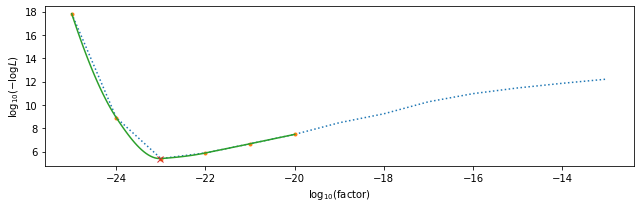

In [54]:
# Determine which factors to tests
factors = 10.**(np.arange(-25, -12, 1))

# Noise estimate to weight the pixels
# Poisson noise + background noise
sig = np.sqrt(data + bkgd_noise**2)

# Tests all these factors
tests = extra.get_tikho_tests(factors=factors, data=data, sig=sig)

# Find the best factor
best_fac = extra.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


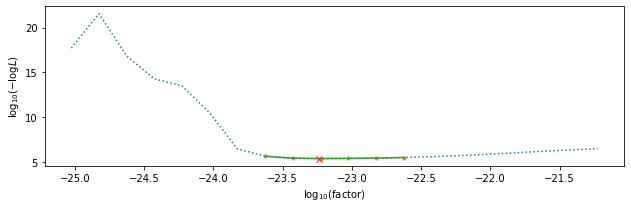

In [55]:
# Refine the grid (span 2 orders of magnitude)
best_fac = np.log10(best_fac)
factors = 10.**(np.arange(best_fac-2, best_fac+2, 0.2))
# No need to specify again `data` and `sig`
tests = extra.get_tikho_tests(factors, data=data, sig=sig)
best_fac = extra.best_tikho_factor(tests=tests, i_plot=True)

### Extract the underlying flux $f_k$
Can be done iteratively for different exposures or different estimates of the reference files

In [56]:
# Extract
f_k = extra.extract(data=data, sig=sig, tikhonov=True, factor=best_fac)

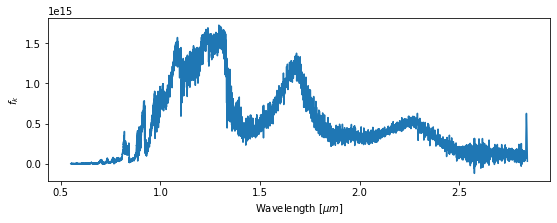

In [57]:
# Plot f_k
plt.plot(extra.lam_grid, f_k)
plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("$f_k$")
plt.show()

### Bin to pixel native sampling
To get a result comparable to typical extraction method, we need to integrate the underlying flux over a grid representative of the native pixel sampling (for each order). The integration is done according to the equation
\begin{equation}
bin_{i} = \int_{\lambda_{ni}^-}^{\lambda_{ni}^+} T_n(\lambda)\tilde{f}_n(\lambda)\lambda d\lambda \, ,
\end{equation}
where $n$ is a given order, $T_n$ is the throughput of the order. The result of this integral will be in fake counts. One could directly extract the integrate flux by setting the throughput to $T_n(\lambda) = 1$, so in code: `def throughput(x): return np.ones_like(x)`

In [58]:
# Save the output in a list for different orders
f_bin_list = []  # Integrated flux
lam_bin_list = []  # Wavelenght grid
for i_ord in range(extra.n_ord):
    # Integrate
    lam_bin, f_bin = extra.bin_to_pixel(f_k=f_k, i_ord=i_ord)
    # Save
    f_bin_list.append(f_bin)
    lam_bin_list.append(lam_bin)

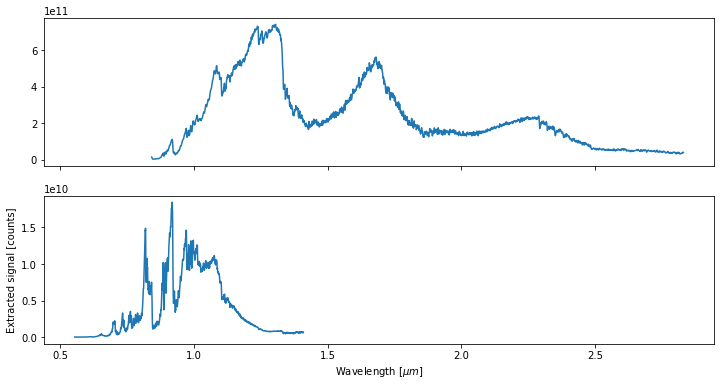

In [59]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))
for i_ord in range(extra.n_ord):
    label = extra.orders[i_ord]
    ax[i_ord].plot(lam_bin_list[i_ord], f_bin_list[i_ord], label=label)
    
ax[1].set_xlabel("Wavelength [$\mu m$]")
ax[1].set_ylabel("Extracted signal [counts]")
plt.show()

## Quality estimate

### Rebuild the detector

In [60]:
rebuilt = extra.rebuild(f_k)

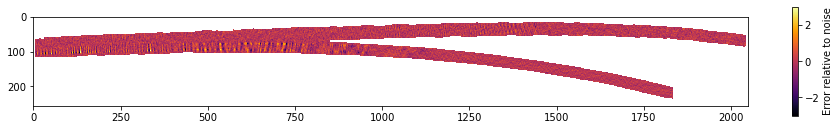

In [61]:
plt.figure(figsize=(16,2))
plt.imshow((rebuilt-data)/sig, vmin=-3, vmax=3)
plt.colorbar(label="Error relative to noise")

We can see that we are very close to the photon limit in this case. There are some small structures in the order 2 where it start to overlap, but it corresponds to a wavelength region covered by order 1 as well, which has much more importance in the fit du to its high signal.